In [ ]:
!nvidia-smi

In [ ]:
from src.sign_visualizer import core

In [1]:
from collections import defaultdict
from datetime import date
from functools import partial
import os
from pathlib import Path
from pprint import pprint
import re
from typing import Any
import torch

from src.metrics import cm
from src.sign_visualizer.core import (
    get_activations,
    load_and_clean,
    load_extractor,
    load_whole_model,
)
from src.sign_visualizer.dataset_interface import (
    ContinualDataset,
    ContinualDatasetConfig,
)


def is_sign_changed(output_1: torch.Tensor, output_2: torch.Tensor):
    return (output_1.mean(0) * output_2.mean(0)) < 0


def is_negative(output_1: torch.Tensor):
    return output_1.mean(0) < 0


def save(container: Any, path: str) -> None:
    torch.save(container, path)


def collect_layers(model, layers):
    compiled_pattern = re.compile(layers)
    matched_layers = [
        (name, module)
        for name, module in model.named_modules()
        if re.match(compiled_pattern, name)
    ]

    if not matched_layers:
        raise ValueError()

    return matched_layers


def scale(output):
    return output - output.mean(0)


def hook_fn(layer_name):
    def hook(module, input, output):
        output = scale(output)
        return output

    return hook


cifar_10_paths = [
    "results/2024/03.14/cifar10_fixed_finetuning_.*after_relu|fc$:var_0.64:cov_12.8",
    # "results/2024/03.14/cifar10_fixed_finetuning_fc$:var_0.64:cov_12.8",
    # "results/2024/03.14/cifar10_fixed_finetuning_noreg",
    # "results/2024/03.21/cifar10_fixed_finetuning",
    # "results/2024/03.22/cifar10_fixed_lwf",
]
cifar_100_paths = [
    "results/2024/03.07/cifar100_fixed_finetuning_after_relu"
    # "results/2024/03.07/cifar100_fixed_finetuning_fc",
    # "results/2024/03.21/cifar100_fixed_ewc",
    # "results/2024/03.21/cifar100_fixed_finetuning",
    # "results/2024/03.21/cifar100_fixed_lwf",
    # "results/2024/03.22/cifar100_fixed_finetuning",
]

paths = cifar_100_paths
for path in paths:
    NUM_TASKS = 5
    NUM_CLASSES = 20
    DEVICE = "cuda"
    # path = (
    #     "results/2024/03.14/cifar10_fixed_finetuning_.*after_relu|fc$:var_0.64:cov_12.8"
    # )
    model = partial(partial(load_whole_model, network="resnet34_skips"), path=path)
    config = ContinualDatasetConfig("cifar100_fixed", NUM_TASKS)
    cl_dataset = ContinualDataset(config)
    dataloader = partial(
        torch.utils.data.DataLoader,
        batch_size=128,
        num_workers=1,
        drop_last=True,
        pin_memory=True,
    )

    tst_loaders = [dataloader(cl_dataset[i, "test"]) for i in range(NUM_TASKS)]

    results = []
    for task_id in range(NUM_TASKS):
        current_model = model(task=task_id, num_classes=NUM_CLASSES).to(DEVICE)
        layers = collect_layers(current_model, ".*after_relu|fc$")

        for name, layer in layers:
            layer.register_forward_hook(hook_fn(name))
        result = cm(
            current_model,
            tst_loaders[: task_id + 1],
            NUM_TASKS,
            DEVICE,
        )
        results.append(result)
        pprint(result)

    save_path = Path("cms", *Path(path).parts[1:])
    os.makedirs(save_path, exist_ok=True)
    save(
        results,
        os.path.join(save_path, "cm.pkl"),
    )

Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>
array([[0.96, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])
<All keys matched successfully>
array([[0.  , 0.96, 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])
<All keys matched successfully>
array([[0.109 , 0.699 , 0.152 , 0.    , 0.    ],
       [0.138 , 0.64  , 0.182 , 0.    , 0.    ],
       [0.0815, 0.748 , 0.1305, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])
<All keys matched successfully>
array([[0.  , 0.  , 0.  , 0.96, 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.  ],
  

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pprint import pprint
import torch


def generate_cm(arrays, labels, title):
    conf_matrices = np.stack(arrays)
    print(len(labels))
    print(conf_matrices.shape)
    num_experiments = conf_matrices.shape[0]
    num_tasks = conf_matrices.shape[1]
    plt.figure(figsize=(5 * num_experiments, 5 * num_tasks))
    plt.suptitle(title)
    for i in range(num_tasks):
        for j in range(num_experiments):
            plt.subplot(num_tasks, num_experiments, i * num_experiments + j + 1)
            plt.imshow(
                conf_matrices[j, i],
                cmap="Blues",
                interpolation="nearest",
                vmin=0,
                vmax=1,
            )
            plt.title(f"Task {i+1}, Experiment {labels[j]}")
            plt.colorbar()
            tick_marks = np.arange(5)
            plt.xticks(tick_marks, tick_marks)
            plt.yticks(tick_marks, tick_marks)
            plt.tight_layout()
            plt.ylabel("True task")
            plt.xlabel("Predicted task")

            # for x in range(conf_matrices.shape[2]):
            #     for y in range(conf_matrices.shape[3]):
            #         plt.text(y, x, '{:.2f}'.format(conf_matrices[j, i, x, y]),
            #                  horizontalalignment='center',
            #                  verticalalignment='center',
            #                  color='black',
            #                  fontsize=10)

    plt.tight_layout
    plt.savefig(f"{title}_cms.png")
    plt.show()

[PosixPath('cms/2024/03.07/cifar100_fixed_finetuning_after_relu/cm.pkl'),
 PosixPath('cms/2024/03.07/cifar100_fixed_finetuning_fc/cm.pkl'),
 PosixPath('cms/2024/03.21/cifar100_fixed_ewc/cm.pkl'),
 PosixPath('cms/2024/03.21/cifar100_fixed_finetuning/cm.pkl'),
 PosixPath('cms/2024/03.21/cifar100_fixed_lwf/cm.pkl'),
 PosixPath('cms/2024/03.22/cifar100_fixed_finetuning/cm.pkl')]
6
(6, 5, 5, 5)


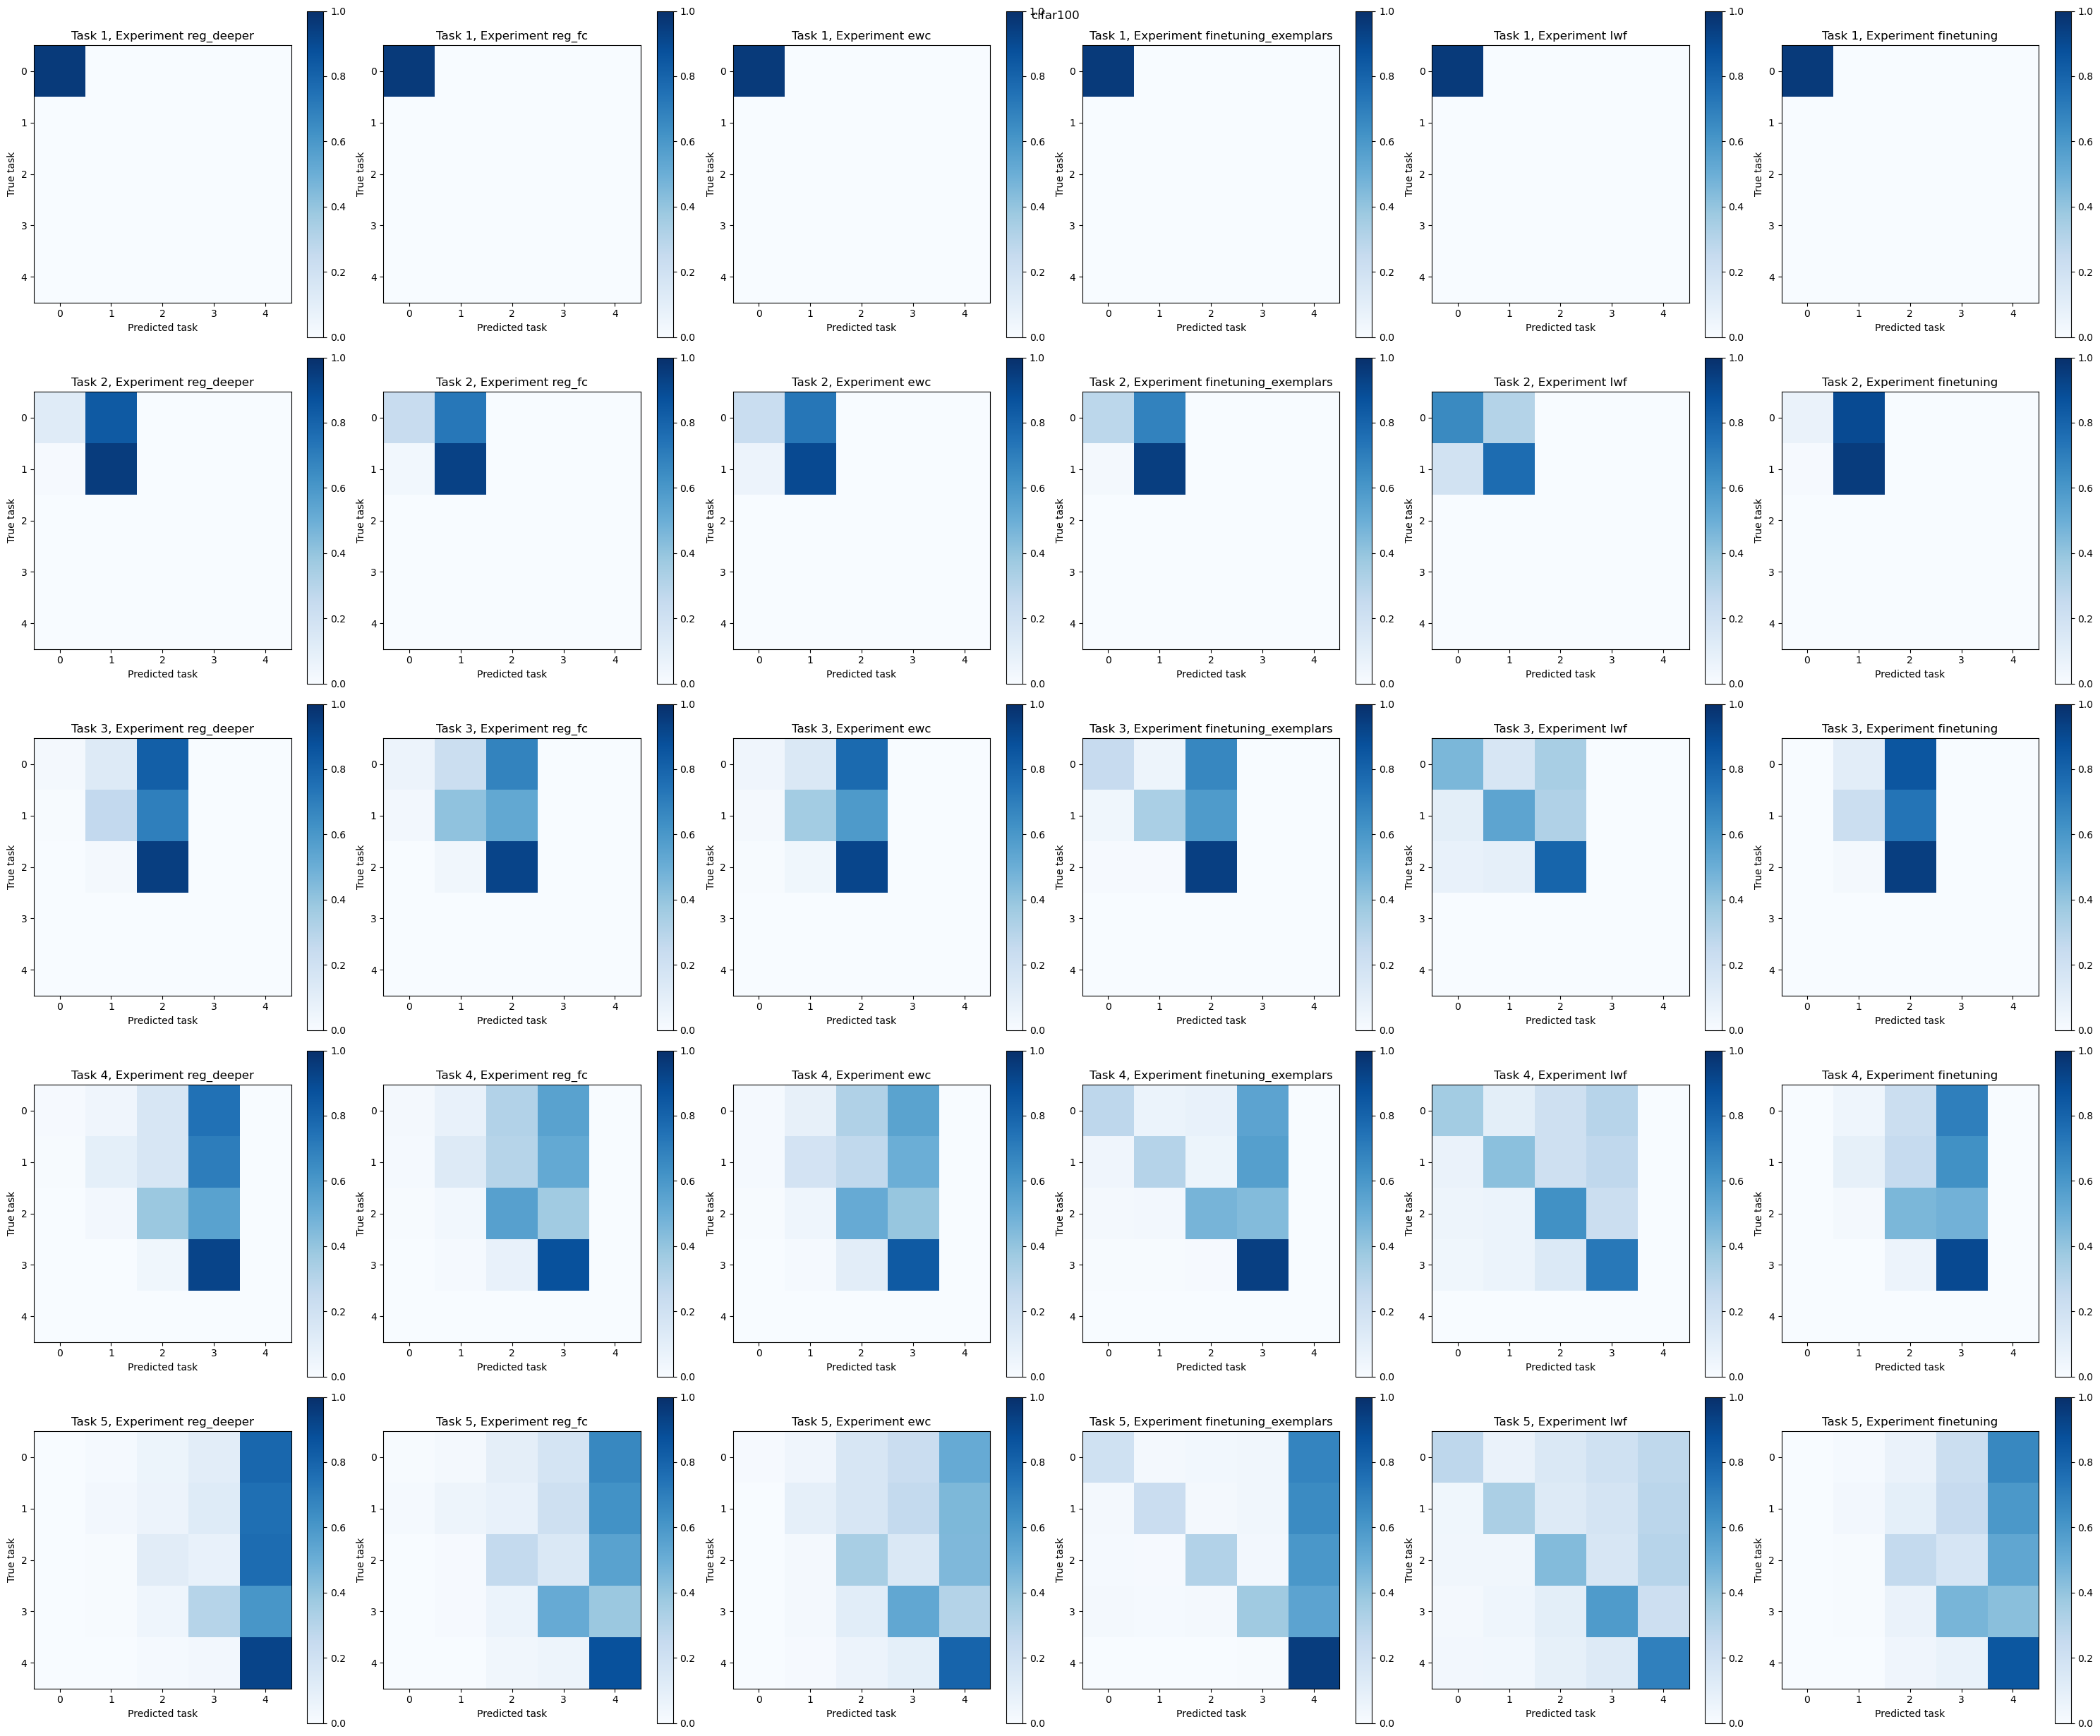

In [8]:
root = Path("cms")
paths = sorted(list(root.rglob("*cifar100_*/*.pkl")))

pprint(paths)
arrays = []


for path in paths:
    ckpt = torch.load(path)
    arrays.append(np.stack(ckpt))

labels_cifar10 = ["reg_deeper", "reg_fc", "noreg", "exemplars", "lwf"]
labels_cfiar100 = [
    "reg_deeper",
    "reg_fc",
    "ewc",
    "finetuning_exemplars",
    "lwf",
    "finetuning",
]  # [path.parts[-2].replace("cifar100_", "") for path in paths]
# plot_rows_on_subfigures(*arrays, labels=labels_cfiar100)
generate_cm(arrays, labels_cfiar100, "cifar100")

[PosixPath('cms/2024/03.14/cifar10_fixed_finetuning_.*after_relu|fc$:var_0.64:cov_12.8/cm.pkl'),
 PosixPath('cms/2024/03.14/cifar10_fixed_finetuning_fc$:var_0.64:cov_12.8/cm.pkl'),
 PosixPath('cms/2024/03.14/cifar10_fixed_finetuning_noreg/cm.pkl'),
 PosixPath('cms/2024/03.21/cifar10_fixed_finetuning/cm.pkl'),
 PosixPath('cms/2024/03.22/cifar10_fixed_lwf/cm.pkl')]
5
(5, 5, 5, 5)


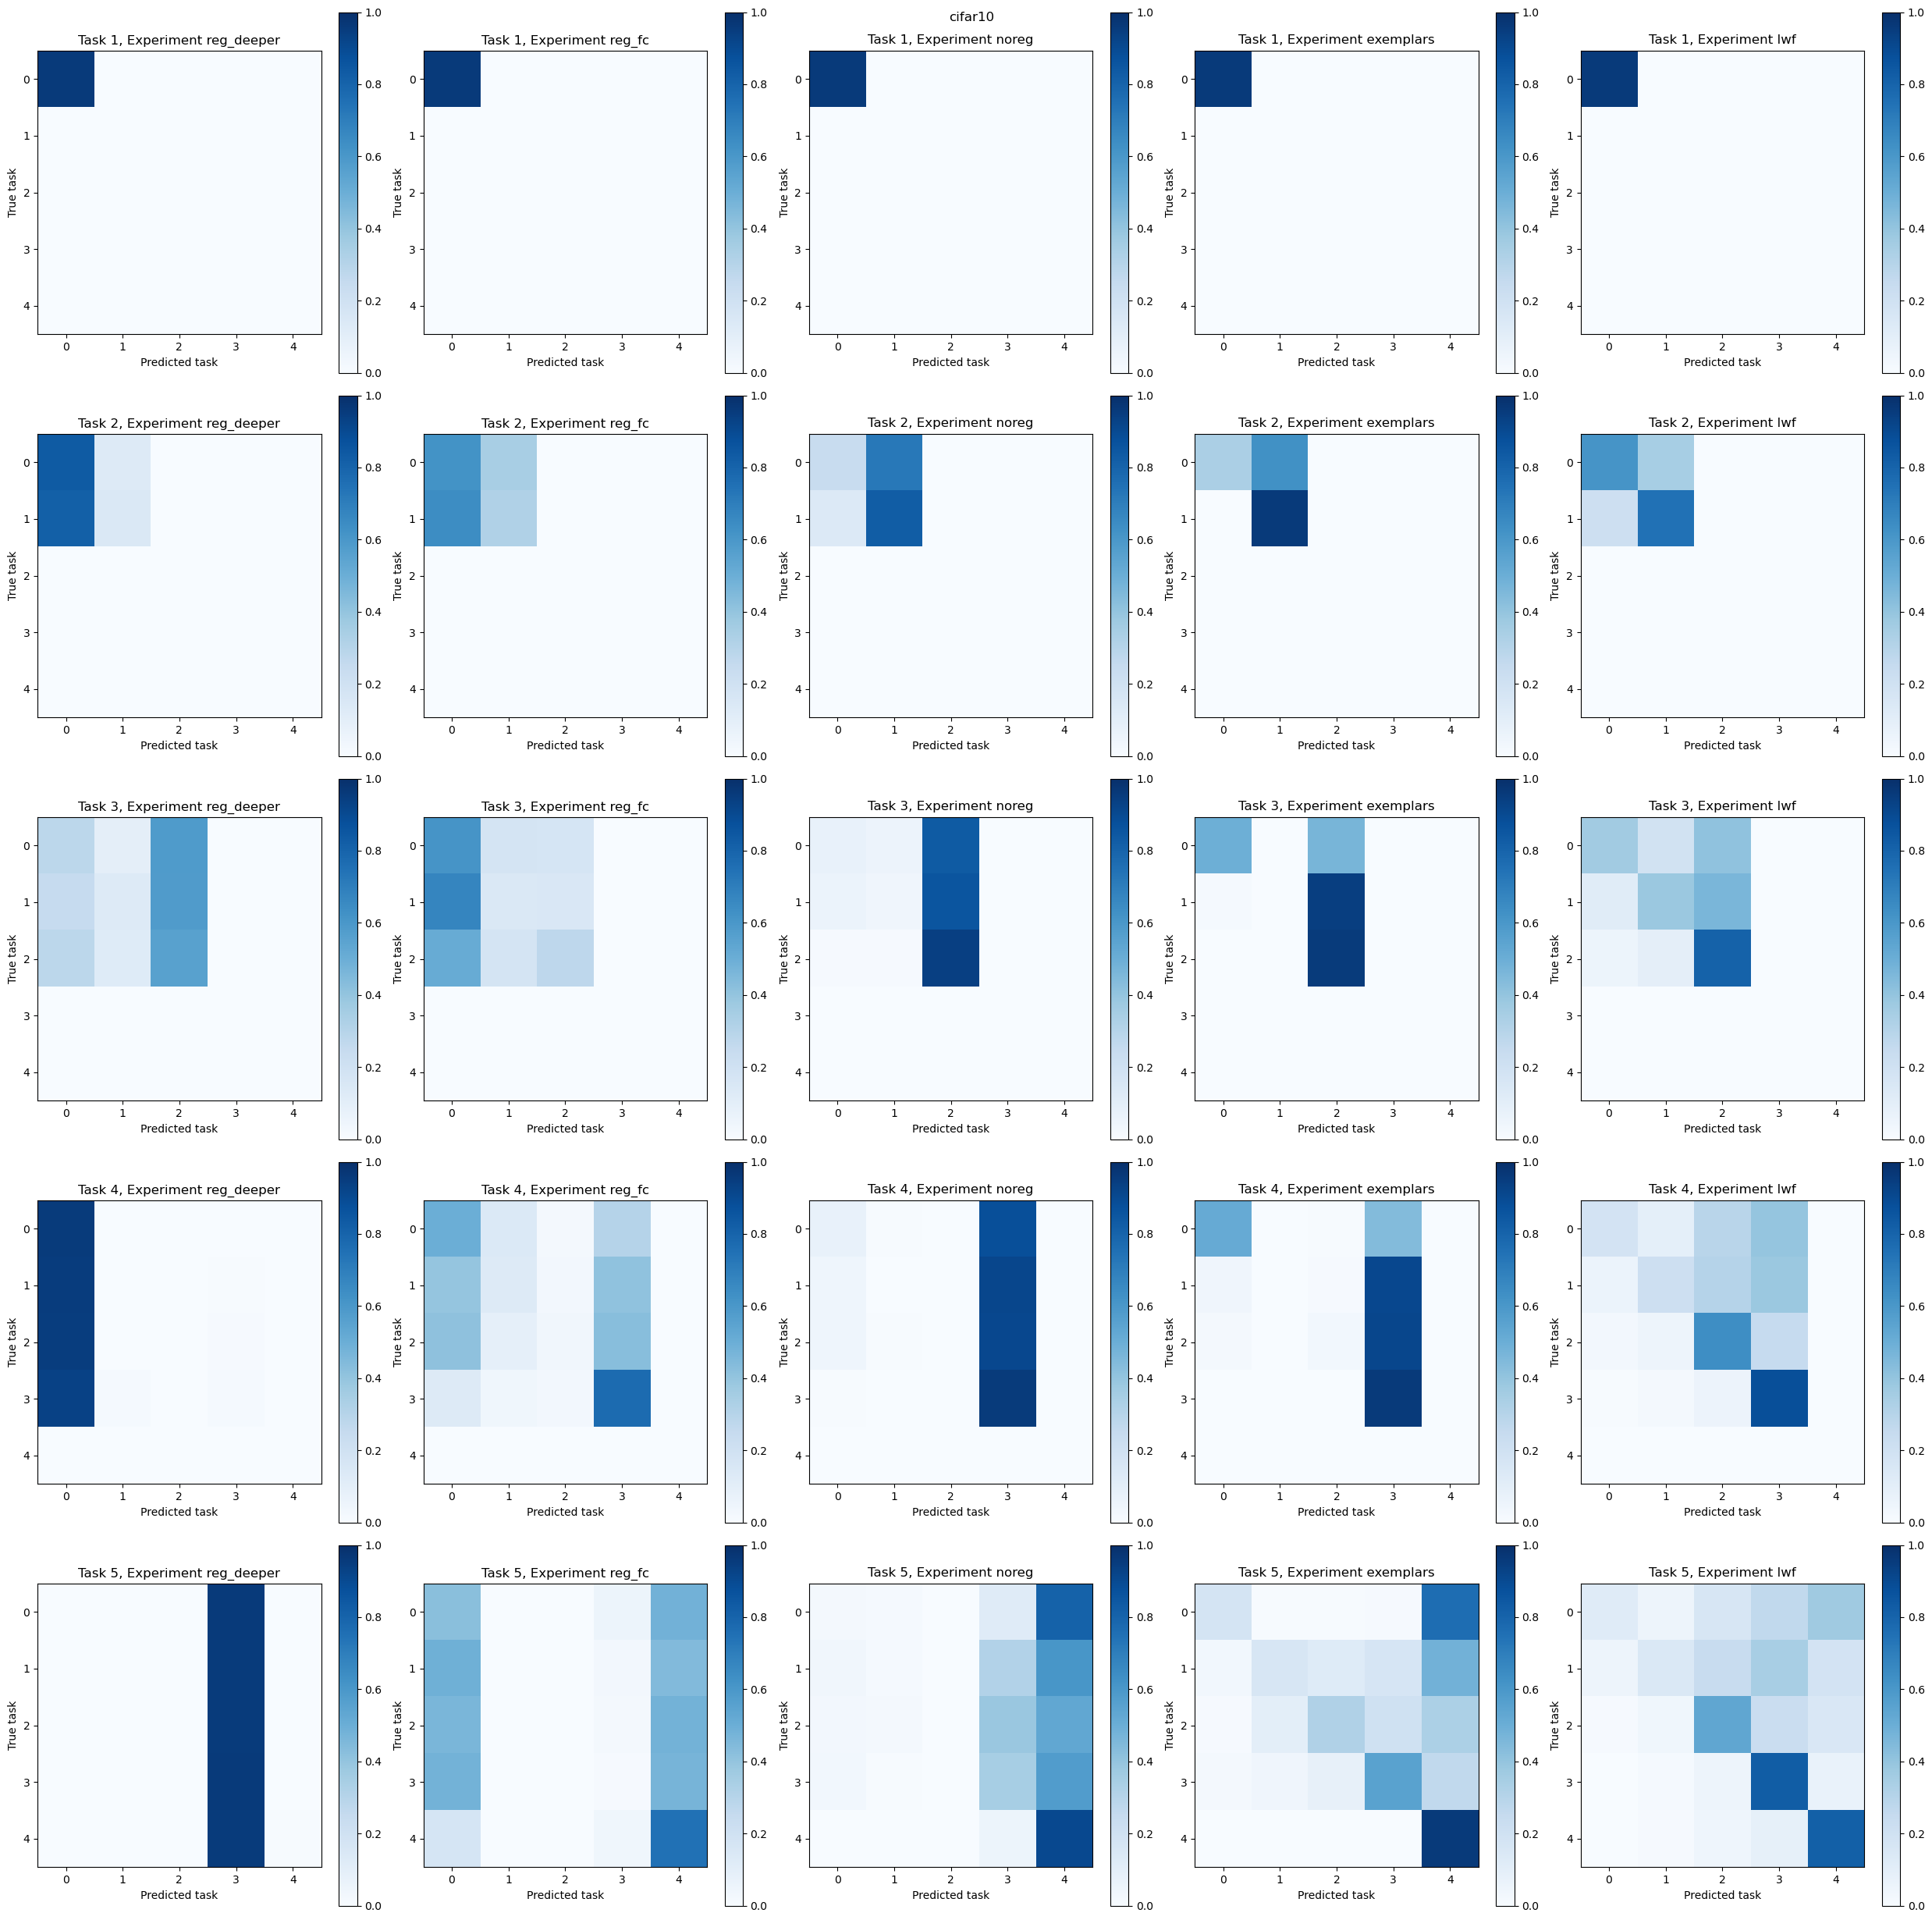

In [365]:
import numpy as np


root = Path("cms")
paths = sorted(list(root.rglob("*cifar10_*/*.pkl")))
pprint(paths)
arrays = []

for path in paths:
    ckpt = torch.load(path)
    arrays.append(np.stack(ckpt))

labels_cifar10 = ["reg_deeper", "reg_fc", "noreg", "exemplars", "lwf"]
labels_cfiar100 = [
    "reg_fc",
    "ewc",
    "finetuning_exemplars",
    "lwf",
    "finetuning",
]  # [path.parts[-2].replace("cifar100_", "") for path in paths]
# plot_rows_on_subfigures(*arrays, labels=labels_cfiar100)
generate_cm(arrays, labels_cifar10, "cifar10")